# Purpose
This notebooks adapts the weights scrapped online to my implementation architecture.

## Import

In [1]:
from collections import OrderedDict
import pandas as pd

import torch
import torchvision
import torch.nn as nn

from glcic.networks.completion_network import CompletionNetwork

# From https://github.com/otenim/GLCIC-PyTorch

## Compare the architectures

In [2]:
# my CN implementation architecure
cn = CompletionNetwork()
cn_state_dict = cn.state_dict()
cn_shapes = OrderedDict([(k, v.shape) for k, v in cn_state_dict.items()])
cn_shapes_serie = pd.Series(cn_shapes.values(),index = cn_shapes.keys())
cn_shapes_serie

cn_net.0.0.weight                  (64, 4, 5, 5)
cn_net.0.0.bias                            (64,)
cn_net.0.2.weight                          (64,)
cn_net.0.2.bias                            (64,)
cn_net.0.2.running_mean                    (64,)
                                       ...      
cn_net.15.2.running_mean                   (32,)
cn_net.15.2.running_var                    (32,)
cn_net.15.2.num_batches_tracked               ()
cn_net.16.0.weight                 (3, 32, 3, 3)
cn_net.16.0.bias                            (3,)
Length: 114, dtype: object

In [3]:
# load weights
obtenim_state_dict = torch.load("../logs/scrapped_weights/model_cn")
obtenim_shapes = OrderedDict([(k, v.shape) for k, v in obtenim_state_dict.items()])
obtenim_shapes_serie = pd.Series(obtenim_shapes.values(),index = obtenim_shapes.keys())
obtenim_shapes_serie

conv1.weight                (64, 4, 5, 5)
conv1.bias                          (64,)
bn1.weight                          (64,)
bn1.bias                            (64,)
bn1.running_mean                    (64,)
                                ...      
bn16.running_mean                   (32,)
bn16.running_var                    (32,)
bn16.num_batches_tracked               ()
conv17.weight               (3, 32, 3, 3)
conv17.bias                          (3,)
Length: 114, dtype: object

In [4]:
# transfer
assert len(obtenim_state_dict) == len(cn_state_dict), "The number of layers is different"
transfer_state_dict = {key1: value2 for key1, value2 in zip(cn_state_dict.keys(), obtenim_state_dict.values())}
cn.load_state_dict(transfer_state_dict)

<All keys matched successfully>

## Test

In [5]:
# load the dataset
train_dataset_dir = '../data/train/'
train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_dir, transform=torchvision.transforms.ToTensor())
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False)

# next batch
batch = next(iter(train_dataloader))[0]

# apply mask
replacement_val = torch.tensor([0.5062325495504219, 0.4255871700324652, 0.38299278586700136])
from glcic.utils import *
lm,em = generate_mask(4)
masked_batch = apply_mask(batch,em,replacement_val)

In [6]:
# complete
cn.eval()
with torch.no_grad():
    input_batch = torch.cat([masked_batch,em[:,None,:,:]],dim=1)[:1]
    completed_batch = cn(input_batch)
_em = em[:,None,:,:].repeat(1,3,1,1)
completed_batch = torch.where(_em,completed_batch,masked_batch)

Text(0.5, 1.0, 'Completed')

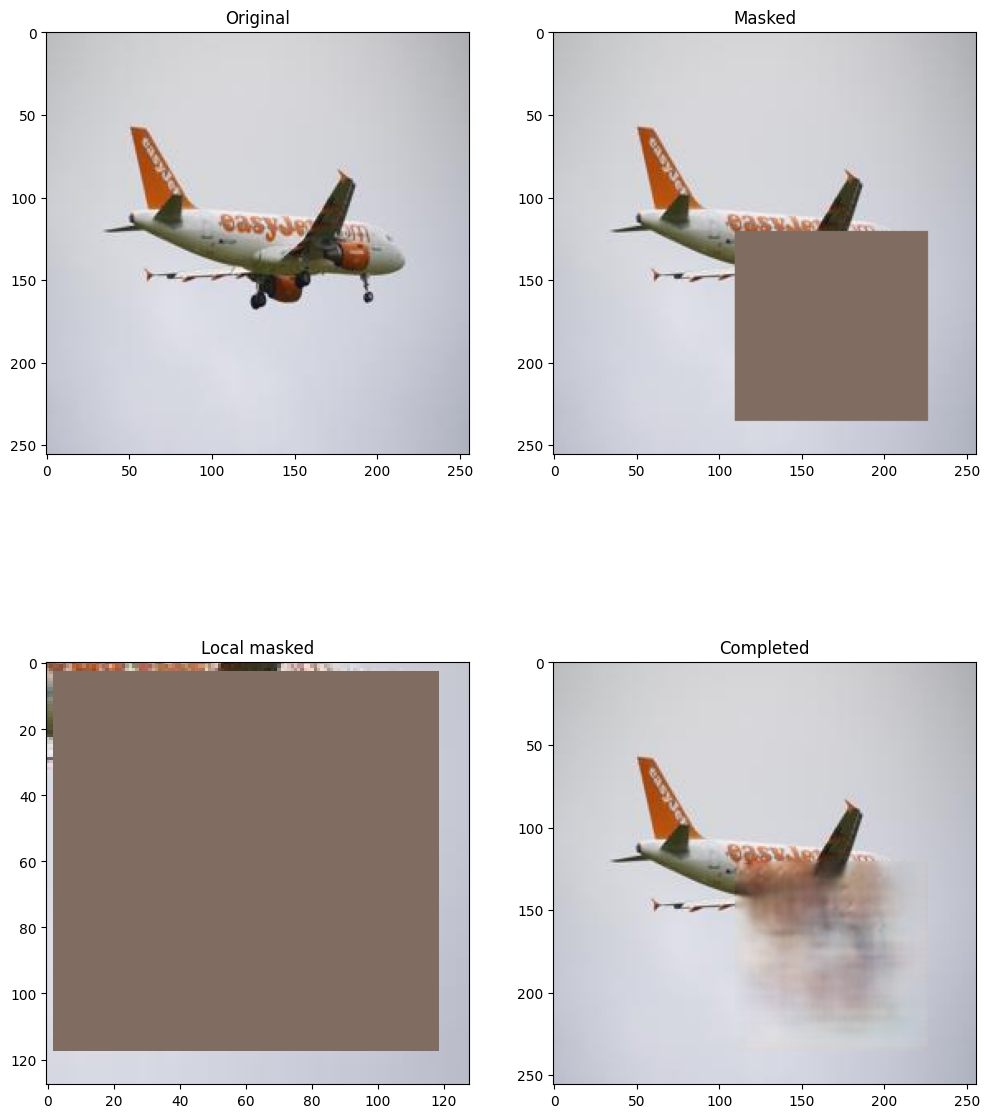

In [7]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,2, figsize=(12,15))

# display the original image
axes[0][0].imshow(batch[0].permute(1,2,0))
axes[0][0].set_title('Original')

# display the masked image
axes[0][1].imshow(masked_batch[0].permute(1,2,0))
axes[0][1].set_title('Masked')

# display the local masked image
h,h2,w,w2 = lm[0]
axes[1][0].imshow(masked_batch[0][:,h:h2,w:w2].permute(1,2,0))
axes[1][0].set_title('Local masked')

# display the completed image
axes[1][1].imshow(completed_batch[0].permute(1,2,0))
axes[1][1].set_title('Completed')